<font size="+3"><strong>Assignment: Predicting Apartment Prices in Mexico City 🇲🇽</strong></font>

In [ ]:
import warnings

import wqet_grader

warnings.simplefilter(action="ignore", category=FutureWarning)
wqet_grader.init("Project 2 Assessment")

<div class="alert alert-block alert-warning">
    <b>Note:</b> In this project there are graded tasks in both the lesson notebooks and in this assignment. Together they total 24 points. The minimum score you need to move to the next project is 22 points. Once you get 22 points, you will be enrolled automatically in the next project, and this assignment will be closed. This means that you might not be able to complete the last two tasks in this notebook. If you get an error message saying that you've already passed the course, that's good news. You can stop this assignment and move onto the project 3. 
</div>

In this assignment, you'll decide which libraries you need to complete the tasks. You can import them in the cell below. 👇

In [116]:
# Import libraries here
import warnings
from glob import glob

import pandas as pd
import seaborn as sns
import wqet_grader
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

import matplotlib.pyplot as plt

# Prepare Data

## Import

**Task 2.5.1:** (8 points) Write a `wrangle` function that takes the name of a CSV file as input and returns a DataFrame. The function should do the following steps:

1. Subset the data in the CSV file and return only apartments in Mexico City (`"Distrito Federal"`) that cost less than \$100,000.
2. Remove outliers by trimming the bottom and top 10\% of properties in terms of `"surface_covered_in_m2"`.
3. Create separate `"lat"` and `"lon"` columns.
4. Mexico City is divided into [16 boroughs](https://en.wikipedia.org/wiki/Boroughs_of_Mexico_City). Create a `"borough"` feature from the `"place_with_parent_names"` column.
5. Drop columns that are more than 50\% null values.
6. Drop columns containing low- or high-cardinality categorical values. 
7. Drop any columns that would constitute leakage for the target `"price_aprox_usd"`.
8. Drop any columns that would create issues of multicollinearity. 

<div class="alert alert-block alert-info">
<b>Tip:</b> Don't try to satisfy all the criteria in the first version of your <code>wrangle</code> function. Instead, work iteratively. Start with the first criteria, test it out with one of the Mexico CSV files in the <code>data/</code> directory, and submit it to the grader for feedback. Then add the next criteria.</div>

In [160]:
files = glob('./data/mexico-city-real-estate-[0-5].csv')
files

['./data/mexico-city-real-estate-5.csv',
 './data/mexico-city-real-estate-2.csv',
 './data/mexico-city-real-estate-1.csv',
 './data/mexico-city-real-estate-3.csv',
 './data/mexico-city-real-estate-4.csv']

In [161]:
frame = []
for i in files:
    df = pd.read_csv(i)
    frame.append(df)
df = pd.concat([i for i in frame])

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23140 entries, 0 to 4627
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   23140 non-null  object 
 1   property_type               23140 non-null  object 
 2   place_with_parent_names     23140 non-null  object 
 3   lat-lon                     20698 non-null  object 
 4   price                       22745 non-null  float64
 5   currency                    22745 non-null  object 
 6   price_aprox_local_currency  22745 non-null  float64
 7   price_aprox_usd             22745 non-null  float64
 8   surface_total_in_m2         8633 non-null   float64
 9   surface_covered_in_m2       22215 non-null  float64
 10  price_usd_per_m2            6012 non-null   float64
 11  price_per_m2                21320 non-null  float64
 12  floor                       1531 non-null   float64
 13  rooms                       621 

In [168]:
# Build your `wrangle` function
def wrangle(filepath):
    df = pd.read_csv(filepath)
    mask1 = (df['property_type'] == 'apartment')
    mask2 = (df['price_aprox_usd'] < 100000)
    mask3 = (df['place_with_parent_names'].str.contains('Distrito Federal'))
    
    
    df = df[mask1 & mask2 & mask3]
    
    low, high = df['surface_covered_in_m2'].quantile([0.1, 0.9])
    maskArea = df['surface_covered_in_m2'].between(low, high)
    df = df[maskArea]
    
    df[['lat', 'lon']] = df['lat-lon'].str.split(',', expand=True).astype(float)
    df = df.drop(columns='lat-lon')
    
    df['borough'] = df['place_with_parent_names'].str.split('|', expand=True)[1]
    df = df.drop(columns='place_with_parent_names')
    
    columns_na = [i for i in df.columns if df[i].isna().sum() > int(len(df)/2)]
    df = df.drop(columns = columns_na)
    
    list_card = ["operation", "property_type",  "currency", "properati_url"]
    df = df.drop(columns = list_card)
    
    #leakage 
    highlow_cardinality = ['price', 'price_aprox_local_currency', 'price_per_m2']
    df = df.drop(columns = highlow_cardinality)
    
    
    
    return df

In [169]:
files = glob('./data/mexico-city-real-estate-[0-5].csv')
files

['./data/mexico-city-real-estate-5.csv',
 './data/mexico-city-real-estate-2.csv',
 './data/mexico-city-real-estate-1.csv',
 './data/mexico-city-real-estate-3.csv',
 './data/mexico-city-real-estate-4.csv']

In [170]:
# Use this cell to test your wrangle function and explore the data
frame = []
for i in files:
    df = wrangle(i)
    frame.append(df)


In [171]:
df = pd.concat(frame)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5473 entries, 1 to 4627
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 256.5+ KB


In [172]:
# low or high cardinality
df.select_dtypes('object').nunique()

borough    15
dtype: int64

In [173]:
list_card = ["operation", "property_type",  "currency", "properati_url"]

<AxesSubplot:>

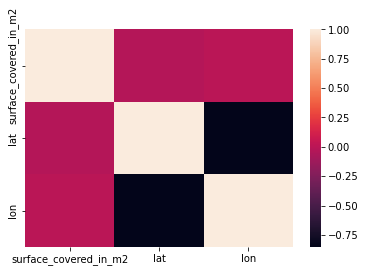

In [174]:
corr = df.select_dtypes('number').drop(columns='price_aprox_usd').corr()
sns.heatmap(corr)

In [175]:
highlow_cardinality = ['price', 'price_aprox_local_currency', 'price_usd_per_m2', 'price_per_m2']

In [176]:
df['price_aprox_usd'].head()

1     82737.39
3     72197.60
4     44277.72
13    60589.45
18    47429.08
Name: price_aprox_usd, dtype: float64

In [177]:
wqet_grader.grade(
    "Project 2 Assessment", "Task 25.1", wrangle("data/mexico-city-real-estate-1.csv")
)

**Task 2.5.2:** Use glob to create the list `files`. It should contain the filenames of all the Mexico City real estate CSVs in the `./data` directory, except for `mexico-city-test-features.csv`.

In [180]:
files = glob('./data/mexico-city-real-estate-[1-5].csv')
files

['./data/mexico-city-real-estate-5.csv',
 './data/mexico-city-real-estate-2.csv',
 './data/mexico-city-real-estate-1.csv',
 './data/mexico-city-real-estate-3.csv',
 './data/mexico-city-real-estate-4.csv']

In [181]:
wqet_grader.grade("Project 2 Assessment", "Task 25.2", sorted(files))

**Task 2.5.3:** Combine your `wrangle` function, a list comprehension, and `pd.concat` to create a DataFrame `df`. It should contain all the properties from the five CSVs in `files`. 

In [133]:
frame = []
for i in files:
    df = wrangle(i)
    frame.append(df)


In [134]:
df = pd.concat(frame)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 848 entries, 11 to 4538
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price_aprox_usd      848 non-null    float64
 1   surface_total_in_m2  848 non-null    float64
 2   lat                  703 non-null    float64
 3   lon                  703 non-null    float64
 4   boroughs             848 non-null    object 
dtypes: float64(4), object(1)
memory usage: 39.8+ KB
None


,price_aprox_usd,surface_total_in_m2,lat,lon,boroughs
11,12445.91,47.0,19.534109,-99.145271,Gustavo A. Madero
34,42149.18,59.0,19.455768,-99.204714,Miguel Hidalgo
59,10579.00,44.0,NaN,NaN,Gustavo A. Madero
62,97469.99,0.0,19.274231,-99.206026,Tlalpan
107,33561.29,65.0,19.425801,-99.059858,Venustiano Carranza


In [136]:
df.shape

(848, 5)

In [182]:
wqet_grader.grade("Project 2 Assessment", "Task 25.3", df)

## Explore

**Task 2.5.4:** Create a histogram showing the distribution of apartment prices (`"price_aprox_usd"`) in `df`. Be sure to label the x-axis `"Area [sq meters]"`, the y-axis `"Count"`, and give it the title `"Distribution of Apartment Prices"`.

What does the distribution of price look like? Is the data normal, a little skewed, or very skewed?

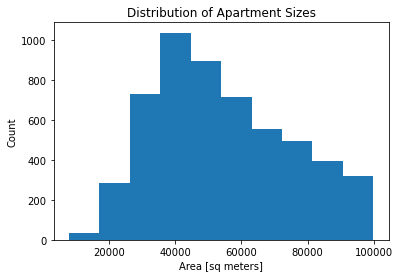

In [192]:
# Plot distribution of price
plt.hist(df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel('Count')
plt.title("Distribution of Apartment Sizes")

# Don't delete the code below 👇
plt.savefig("images/25-4.png", dpi=150)

In [193]:
with open("images/25-4.png", "rb") as file:
    wqet_grader.grade("Project 2 Assessment", "Task 25.4", file)

**Task 2.5.5:** Create a scatter plot that shows apartment price (`"price_aprox_usd"`) as a function of apartment size (`"surface_covered_in_m2"`). Be sure to label your axes `"Price [USD]"` and `"Area [sq meters]"`, respectively. Your plot should have the title `"Mexico City: Price vs. Area"`.

Do you see a relationship between price and area in the data? How is this similar to or different from the Buenos Aires dataset?

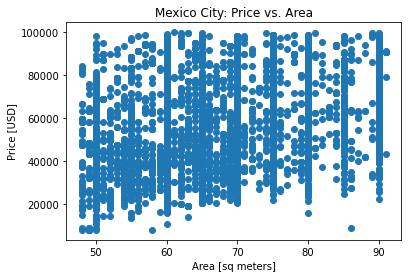

In [198]:
# Plot price vs area
plt.scatter(x = df['surface_covered_in_m2'], y=df['price_aprox_usd'], )
plt.ylabel('Price [USD]')
plt.xlabel('Area [sq meters]')
plt.title('Mexico City: Price vs. Area')
# Don't delete the code below 👇
plt.savefig("images/25-5.png", dpi=150)

In [199]:
with open("images/25-5.png", "rb") as file:
    wqet_grader.grade("Project 2 Assessment", "Task 25.5", file)

**Task 2.5.6:** **(UNGRADED)** Create a Mapbox scatter plot that shows the location of the apartments in your dataset and represent their price using color. 

What areas of the city seem to have higher real estate prices?

In [ ]:
# Plot Mapbox location and price


## Split

**Task 2.5.7:** Create your feature matrix `X_train` and target vector `y_train`. Your target is `"price_aprox_usd"`. Your features should be all the columns that remain in the DataFrame you cleaned above.

In [200]:
df.columns

Index(['price_aprox_usd', 'surface_covered_in_m2', 'lat', 'lon', 'borough'], dtype='object')

In [202]:
# Split data into feature matrix `X_train` and target vector `y_train`.
feature = 'price_aprox_usd'
X_train = df[['surface_covered_in_m2', 'lat', 'lon', 'borough']]
y_train = df[feature]

In [203]:
wqet_grader.grade("Project 2 Assessment", "Task 25.7a", X_train)

In [205]:
wqet_grader.grade("Project 2 Assessment", "Task 25.7b", y_train)

# Build Model

## Baseline

**Task 2.5.8:** Calculate the baseline mean absolute error for your model.

In [210]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54246.5314982643
Baseline MAE: 17239.939475888303


In [211]:
wqet_grader.grade("Project 2 Assessment", "Task 25.8", [baseline_mae])

## Iterate

**Task 2.5.9:** Create a pipeline named `model` that contains all the transformers necessary for this dataset and one of the predictors you've used during this project. Then fit your model to the training data.

In [214]:
model = make_pipeline(
    OneHotEncoder(use_cat_names = True), 
    SimpleImputer(),
    Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [215]:
wqet_grader.grade("Project 2 Assessment", "Task 25.9", model)

## Evaluate

**Task 2.5.10:** Read the CSV file `mexico-city-test-features.csv` into the DataFrame `X_test`.

In [217]:
X_test = pd.read_csv('./data/mexico-city-test-features.csv')
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   float64
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(3), object(1)
memory usage: 32.7+ KB
None


,surface_covered_in_m2,lat,lon,borough
0,60.0,19.493185,-99.205755,Azcapotzalco
1,55.0,19.307247,-99.166700,Coyoacán
2,50.0,19.363469,-99.010141,Iztapalapa
3,60.0,19.474655,-99.189277,Azcapotzalco
4,74.0,19.394628,-99.143842,Benito Juárez


In [218]:
wqet_grader.grade("Project 2 Assessment", "Task 25.10", X_test)

**Task 2.5.11:** Use your model to generate a list of predictions for `X_test`. When you submit your predictions to the grader, it will calculate the mean absolute error for your model.

In [219]:
y_test_pred = model.predict(X_test)

In [220]:
wqet_grader.grade("Project 2 Assessment", "Task 25.11", list(y_test_pred))

# Communicate Results

**Task 2.5.12:** Create a Series named `feat_imp`. The index should contain the names of all the features your model considers when making predictions; the values should be the coefficient values associated with each feature. The Series should be sorted ascending by absolute value.  

In [221]:
features = df.columns

In [226]:
coefficients = model.named_steps['ridge'].coef_

In [227]:
coefficients

array([   291.65415588,    478.90137462,  -2492.22181412,  13778.18887983,
        10319.42980445, -13349.01744766,  -6637.42975669,  -5609.91862933,
          405.40312735,   3737.56100072,   -350.53199047,   1977.31471761,
         2459.28864612, -14166.86948588,   3275.12106108,  -5925.66645029,
          929.85739998,   9157.26912312])

In [241]:
dir(model.named_steps['ridge'])

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_decision_function',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_normalize',
 '_preprocess_data',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_set_intercept',
 '_validate_data',
 'alpha',
 'coef_',
 'copy_X',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'max_iter',
 'n_features_in_',
 'n_iter_',
 'normalize',
 'positive',
 'predict',
 'random_state',
 'score',
 'set_params',
 'solver',
 'tol']

In [246]:
model.named_steps['ridge'].get_params

<bound method BaseEstimator.get_params of Ridge()>

In [228]:
coefficients = model.named_steps['ridge'].coef_
features = 
feat_imp = pd.Series(coefficients[0:4], index=features)
feat_imp

surface_covered_in_m2      291.654156
lat                        478.901375
lon                      -2492.221814
borough                  13778.188880
dtype: float64

In [229]:
wqet_grader.grade("Project 2 Assessment", "Task 25.12", feat_imp)

**Task 2.5.13:** Create a horizontal bar chart that shows the **10 most influential** coefficients for your model. Be sure to label your x- and y-axis `"Importance [USD]"` and `"Feature"`, respectively, and give your chart the title `"Feature Importances for Apartment Price"`.

In [ ]:
# Create horizontal bar chart

# Don't delete the code below 👇
plt.savefig("images/25-14.png", dpi=150)

In [ ]:
with open("images/25-14.png", "rb") as file:
    wqet_grader.grade("Project 2 Assessment", "Task 25.13", file)

---
Copyright © 2022 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
